## Fairness-aware binary classification for the adult dataset
This notebook works on the adult dataset: https://archive.ics.uci.edu/ml/datasets/adult. The dataset consists of circa 48k data points and 14 attributes, including two sensitive (or protected) attributes: 
- **sex**: {Female, Male}
- **race**: {White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black}

The target variable is binary and its goal is to predict whether an individual's annual income is <=50k or >50k. The focus of the notebook is the identification and correction of possible unfair treatment of individuals or groups, using the AIF360 toolset. To that aim, the below steps are followed:
1. Data loading and fairness properties
2. Fairness and bias-related exploratory data analysis
3. Feature pre-processing/engineering
4. Model training, bias removal and evaluation

In [1]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm # progress bar
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from aif360.datasets import AdultDataset # inherits from StandardDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
# inline browser plots for jupyter-notebooks
%matplotlib inline

### Single protected attribute: sex
This section analyses the bias induced by the protected attribute 'sex'. From the attribute's values, 'Male' is considered the privileged class. The analysis takes into consideration only the numerical features of the dataset since they were found to result in a reasonably performant prediction model.

In [2]:
# Dataset properties
protected = 'sex'
privileged = ['Male']
p = [{protected: 1}] # privileged group (males)
u = [{protected: 0}] # unprivileged group (females)
# Feature categories
num_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'] # numerical features
cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country'] # categorical features
# Dataset instantiation
ad = AdultDataset(
    protected_attribute_names=[protected],
    privileged_classes=[privileged],
    categorical_features=[],
    features_to_keep=num_features
)
# Verify that the dataset was initialized properly
print('Features:', ad.feature_names)
print('Target:', ad.label_names)

Features: ['age', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Target: ['income-per-year']


Base rate on entire population: 0.24
Base rate on privileged group (males) :0.11
Base rate on unprivileged group (females) :0.30
Statistical parity difference: -0.19
Disparate impact: 0.36


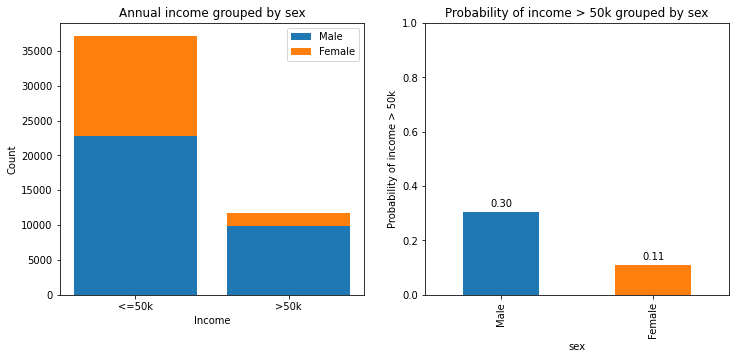

In [3]:
# Fairness-based exploratory data analysis
#
# Since the code is being used more than once in this notebook, it was defined as a function
def analyze_fairness(dataset, df):
    # Separate income by group
    female_income = df[df['sex'] == 0]['income-per-year'] # female == 0
    male_income = df[df['sex'] == 1]['income-per-year'] # male == 1
    # Dataset metrics
    dm = BinaryLabelDatasetMetric(dataset, privileged_groups=p, unprivileged_groups=u)
    print('Base rate on entire population: {:.2f}'.format(dm.base_rate())) # privileged = None
    print('Base rate on privileged group (males) :{:.2f}'.format(dm.base_rate(privileged=False)))
    print('Base rate on unprivileged group (females) :{:.2f}'.format(dm.base_rate(privileged=True)))
    print('Statistical parity difference: {:.2f}'.format(dm.mean_difference()))
    print('Disparate impact: {:.2f}'.format(dm.disparate_impact()))
    # Plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5)) # [1 x 2] grid
    ax1.bar(['<=50k', '>50k'], male_income.value_counts(), label='Male')
    ax1.bar(['<=50k', '>50k'], female_income.value_counts(), bottom=male_income.value_counts(), label='Female')
    ax1.set_xlabel('Income')
    ax1.set_ylabel('Count')
    ax1.set_title('Annual income grouped by sex')
    ax1.legend()
    ax2_y = df.groupby('sex')['income-per-year'].mean().sort_values(ascending=False)
    ax2_y.plot.bar(x=['Male', 'Female'], color=['#1f77b4', '#ff7f0e'], ylim=[0, 1])
    ax2.set_ylabel('Probability of income > 50k')
    ax2.set_title('Probability of income > 50k grouped by sex')
    ax2.set_xticklabels(['Male', 'Female'])
    for i, v in enumerate(ax2_y):
        ax2.text(i-0.07, v+0.02, '{:.2f}'.format(v))
    plt.show()

# Convert dataset to dataframe
ad_df, _ = ad.convert_to_dataframe()
# Call function
analyze_fairness(ad, ad_df)

### Comments
- The **'sex'** attribute is dominated by 'Male' with 67% compared to 'Female' values with 33%. Note: the dominance of 'Male' value does not by itself indicate bias/unfair treatment.
- The percentage of males with income > 50k w.r.t. total sample is 20%. The respective percentage of females is 4%.
- The within-class percentage of females with income > 50k is 11%. The respective percentage for males is 30%.
- A number of fairness metrics were calculated for the dataset at hand. More specifically, **statistical parity difference** and **disparate impact** indicate the existence of bias in the dataset.

Note: **Base rate** is defined as $P(Y=1) = P/(P+N)$, optionally conditioned on protected attribute.

In [4]:
# Feature pre-processing/engineering
#
# Split dataset object to train and test partitions
ad_train, ad_test = ad.split([0.7]) # 0.7 for train, 0.3 for test
# Feature scaling
scaler = MinMaxScaler() # choose min-max scaling
ad_train.features = scaler.fit_transform(ad_train.features) # fit and transform train (seen) features
ad_test.features = scaler.transform(ad_test.features) # transform test (unseen) features
# Keep index of the protected attribute
protected_idx = ad_train.feature_names.index(protected)
# Verify training and test set dimensions
print('Training set dimensions:', ad_train.features.shape)
print('Test set dimensions:', ad_test.features.shape)

Training set dimensions: (34189, 6)
Test set dimensions: (14653, 6)


## Single model evaluation
The following section applies the Disparate Impact Remover algorithm provided in AIF360 to remove bias measured in terms of disparate impact. This algorithm is applied to the original dataset as a pre-processing step and edits the feature set to increase group fairness. It also provides a hyperparameter **repair_level** which is the repair amount (0.0 is no repair while 1.0 is full repair). Even though the focus is on disparate impact, the evaluation process includes an additional set of metrics w.r.t. (mis)classification rate differences.

In [5]:
# Single model training, bias removal and evaluation
#
# Logistic Regression
#lr = LogisticRegression(solver='newton-cg') # Newton's conjugate gradient learning method
lr = LogisticRegression(class_weight='balanced', solver='liblinear')
# Metric scores
accuracy_list = [] # accuracy
spd_list = [] # statistical parity difference
di_list = []  # disparate impact
fprd_list = [] # false positive rate difference
fnrd_list = [] # false negative rate difference
errd_list = [] # error rate difference
#
# Experiment with different repair levels
for level in tqdm(np.arange(0., 1.1, 0.1)):
    # Algorithms for bias removal
    di_remover = DisparateImpactRemover(repair_level=level, sensitive_attribute='sex')

    # Repaired versions of train and test dataset objects
    ad_train_rep = di_remover.fit_transform(ad_train)
    ad_test_rep = di_remover.fit_transform(ad_test)

    # Construct X_train, X_test, y_train and y_test
    X_train = np.delete(ad_train_rep.features, protected_idx, axis=1)
    X_test = np.delete(ad_test_rep.features, protected_idx, axis=1)
    y_train = ad_train_rep.labels.ravel()
    y_test = ad_test_rep.labels.ravel()

    # Training and prediction
    lr.fit(X_train, y_train) # fit
    ad_test_rep_pred = ad_test_rep.copy() # need both dataset objects due to their different labels
    ad_test_rep_pred.labels = lr.predict(X_test) # prediction

    # Dataset metric
    dm = BinaryLabelDatasetMetric(ad_test_rep_pred, privileged_groups=p, unprivileged_groups=u)
    di_list.append(dm.disparate_impact())
    # Classification metric
    cm = ClassificationMetric(ad_test_rep, ad_test_rep_pred, privileged_groups=p, unprivileged_groups=u)
    # Metric calculations
    accuracy_list.append(cm.accuracy())
    fprd_list.append(cm.false_positive_rate_difference())
    fnrd_list.append(cm.false_negative_rate_difference())
    errd_list.append(cm.error_rate_difference())
    spd_list.append(cm.mean_difference())

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:42<00:00,  3.89s/it]


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


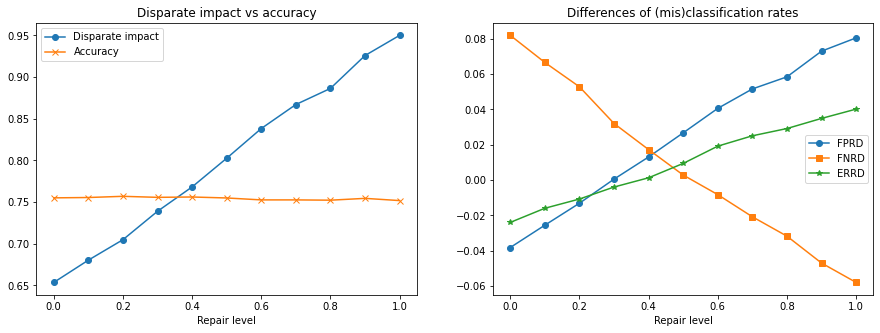

In [6]:
# Visualization of results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5)) # [1 x 2] grid
ax1.plot(np.arange(0., 1.1, 0.1), di_list, marker='o')
ax1.plot(np.arange(0., 1.1, 0.1), accuracy_list, marker='x')
ax1.set_xlabel('Repair level')
ax1.legend(['Disparate impact', 'Accuracy'])
ax1.set_title('Disparate impact vs accuracy')
ax2.plot(np.arange(0., 1.1, 0.1), fprd_list, marker='o')
ax2.plot(np.arange(0., 1.1, 0.1), fnrd_list, marker='s')
ax2.plot(np.arange(0., 1.1, 0.1), errd_list, marker='*')
ax2.set_xlabel('Repair level')
ax2.legend(['FPRD', 'FNRD', 'ERRD'])
ax2.set_title('Differences of (mis)classification rates')
plt.show()

### Comments
- The fairness-unaware performance of the Logistic Regression model is obtained with repair_level=0, for a specified set of model hyperparameters e.g. solver. For example, the newton-cg solver achieves better accuracy than liblinear solver, however the bias removal task is more challenging.
- By increasing the **repair_level**, disparate impact score increases resulting to a fairer classifier; at the same time, the **accuracy** is not affected. For repair_level=1 we achieve the best disparate impact ratio equal to 0.95.
- As far as **(mis)classification rate differences** are concerned, by removing disparate impact the respective FPRD and FNRD metrics are also reduced, up until a point (repair_level~0.4) where they reach a value close to 0. By increasing repair_level more than this threshold, the differences begin to increasea again, in the opposite direction. Finally, the ERRD is not reduced when treating for disparate impact.

**Note**: brief explanation of the (mis)classification rate differences that are included in the second plot:
- **FPRD** (False Positive Rate Difference): $FPR_{D=unprivileged}−FPR_{D=privileged}$
- **FNRD** (False Negative Rate Difference): $FNR_{D=unprivileged}−FNR_{D=privileged}$
- **ERRD** (Error Rate Difference): Difference in error rates for unprivileged and privileged groups, $ERR_{D=unprivileged}−ERR_{D=privileged}$, and $ERR=(FP+FN)/(P+N)$

Base rate on entire population: 0.34
Base rate on privileged group (males) :0.33
Base rate on unprivileged group (females) :0.34
Statistical parity difference: -0.02
Disparate impact: 0.95


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


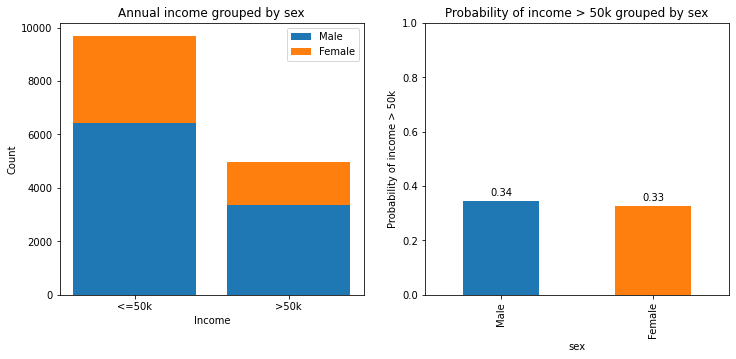

In [7]:
# Visualize bias in repaired test set
#
# Create dataframe from test set
sex = ad_test_rep_pred.features[:,protected_idx]
inc = ad_test_rep_pred.labels
ad_test_rep_pred_df = pd.DataFrame({'sex':sex, 'income-per-year':inc})
# Call fairness analysis function
analyze_fairness(ad_test_rep_pred, ad_test_rep_pred_df)

## Cross-model evaluation
In this section, several classification models are applied to the problem and their performance both on accuracy and fairness is evaluated.

In [8]:
# Cross-model evaluation
#
# Model definitions
gnb = GaussianNB()
knn = KNeighborsClassifier()
lr1 = LogisticRegression(solver='newton-cg')
lr2 = LogisticRegression(class_weight='balanced', solver='liblinear')
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
models = [gnb, knn, lr1, lr2, rf, gb] # list of all model instances
model_names = ['gnb', 'knn', 'lr1', 'lr2', 'rf', 'gb'] # names used for plotting

# Metric scores
accuracy_list = [] # accuracy
di_list = []  # disparate impact
fprd_list = [] # false positive rate difference
fnrd_list = [] # false negative rate difference
errd_list = [] # error rate difference

# Algorithm for bias removal
di_remover = DisparateImpactRemover(repair_level=1.0, sensitive_attribute='sex')
# Repaired versions of train and test dataset objects
ad_train_rep = di_remover.fit_transform(ad_train)
ad_test_rep = di_remover.fit_transform(ad_test)

# Construct X_train, X_test, y_train and y_test
X_train = np.delete(ad_train_rep.features, protected_idx, axis=1)
X_test = np.delete(ad_test_rep.features, protected_idx, axis=1)
y_train = ad_train_rep.labels.ravel()
y_test = ad_test_rep.labels.ravel()

# Loop over models
for model in models:
    # Training and prediction
    print('Training', type(model).__name__)
    model.fit(X_train, y_train) # fit
    ad_test_rep_pred = ad_test_rep.copy() # need both dataset objects due to their different labels
    ad_test_rep_pred.labels = model.predict(X_test) # prediction
    
    # Dataset metric
    dm = BinaryLabelDatasetMetric(ad_test_rep_pred, privileged_groups=p, unprivileged_groups=u)
    di_list.append(dm.disparate_impact())
    
    # Classification metric
    cm = ClassificationMetric(ad_test_rep, ad_test_rep_pred, privileged_groups=p, unprivileged_groups=u)
    # Metric calculations
    accuracy_list.append(cm.accuracy())
    fprd_list.append(cm.false_positive_rate_difference())
    fnrd_list.append(cm.false_negative_rate_difference())
    errd_list.append(cm.error_rate_difference())
    spd_list.append(cm.mean_difference())

print('Done.')

Training GaussianNB
Training KNeighborsClassifier
Training LogisticRegression
Training LogisticRegression
Training RandomForestClassifier
Training GradientBoostingClassifier
Done.


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


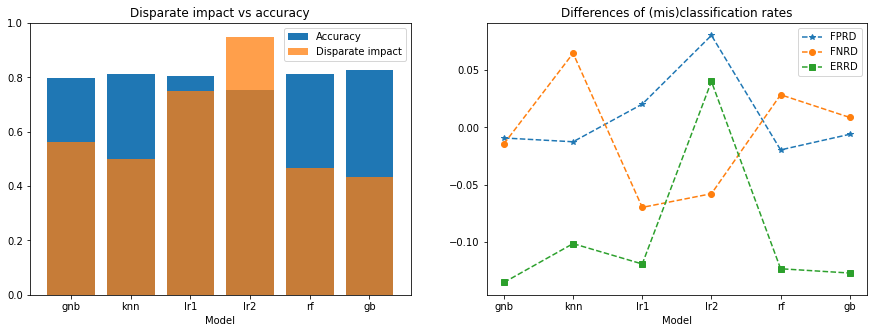

In [9]:
# Visualization of results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5)) # [1 x 2] grid
# 1
ax1.bar(range(len(models)), accuracy_list)
ax1.bar(range(len(models)), di_list, alpha=0.75)
ax1.set_ylim([0, 1])
ax1.set_xlabel('Model')
ax1.legend(['Accuracy', 'Disparate impact'])
ax1.set(xlabel="Model",title='Disparate impact vs accuracy', xticks=np.arange(len(models)), xticklabels=model_names)
# 2
ax2.plot(range(len(models)), fprd_list, marker='*', linestyle='dashed')
ax2.plot(range(len(models)), fnrd_list, marker='o', linestyle='dashed')
ax2.plot(range(len(models)), errd_list, marker='s', linestyle='dashed')
ax2.set_xlabel('Model')
ax2.legend(['FPRD', 'FNRD', 'ERRD'])
ax2.set(xlabel="Model",title='Differences of (mis)classification rates', xticks=np.arange(len(models)), xticklabels=model_names)
plt.show()

### Comments
- The experiments were conducted for several classification models/algorithms with bias removal using Disparate Impact Remover algorithm and a repair level of 1.0 (full repair).
- Different classification algorithms result in different levels of accuracy and bias. For example, the logistic regression algorithm using the liblinear solver achieves very high disparate impact value (making it the fairest), but at a cost of accuracy which is significantly lower compared to the rest of the models. On the other hand, a member of the same family, i.e. logistic regression with newton-cg solver results in better accuracy but significantly lower value of disparate impact.
- The second plot displays the (mis)classification metrics FPRD, FNRD and ERRD. The logistic regression model using liblinear solver achieves the best ERRD (however still non-zero).

**Note**: The second graph should be interpreted as a discrete point plot and not as a continuous line-graph. The dashed lines were included to help visualization.